In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pylhe

from Mu2e import plot_tools, const, models

In [19]:
# Define the path to the MadGraph directory
path_to_madgraph = os.path.expanduser('~/Development/MG5_aMC_v3_5_0')  # NOTE: Change this to your MadGraph installation path
notebook_path = os.getcwd( )

In [20]:
def get_events(filename):
    mg5events = pylhe.read_lhe_with_attributes(filename)

    # Create akward array objects for convinience
    mg5events = pylhe.to_awkward(mg5events)

    return mg5events

def get_spectrum_in_bins(p, bins, weights = None):
    di, _ = np.histogram(p, bins, weights = weights)
    return np.array(di)

## MadGraph functions

In [21]:
def get_mgevents_mucapture(model, process='mu- pp > vm chi1 e+ e-', output='MuonCaptureModel1', generate=True, HTML_opening=False, nevents=1e3):

    if model.muon_capture_open:
        full_output_path = f'{notebook_path}/MGevents/{output}'
        custom_name = f'custom_run_{model.m1:.2e}_{model.m2:.2e}_{model.maprime:.2e}'
        
        # Create a command file with all the instructions for MadGraph
        mg5_commands = f"""
        set automatic_html_opening {HTML_opening}
        import model ExoticMuonCaptureModel1
        generate {process} QEDp<=5
        output {full_output_path}
        launch -n {custom_name} {full_output_path} 
        0
        set ptl -1
        set etal -1
        set etalmin -1
        set drll -1
        set nevents 50000
        set ebeam1 0.00001
        set ebeam2 0.00001
        set Mchi1 {model.m1:.2e}
        set Mchi2 {model.m2:.2e}
        set MAp {model.maprime:.2e}
        set nevents {int(nevents)}"
        0
        """

        if generate:
            # Save the commands to a file
            with open('mg5_script.txt', 'w') as file:
                file.write(mg5_commands)

            # Run the MadGraph script
            os.system(f'{path_to_madgraph}/bin/mg5_aMC mg5_script.txt > {notebook_path}/MGevents/MGlogfile.txt')

        # Move the LHE events to the desired path
        lhe_file_path = f'{full_output_path}/Events/{custom_name}/unweighted_events.lhe.gz'
        
        # Collect events after unzipping
        return get_events(lhe_file_path)
    else:
        print("Muon capture kinematically forbidden.")
        return None

In [22]:
def get_mgevents_pdecay(model, process='pp > e+ vm~ ve vm chi1 e+ e-', output='ProtonDecayModel1', generate=True, HTML_opening=False, nevents=1e3):
    
    if len(model.get_open_pdecay_channels()) > 1:
        print("Decay channels:", model.get_open_pdecay_channels())
        # raise ValueError('Multiple proton decay channels detected')

    full_output_path = f'{notebook_path}/MGevents/{output}'
    custom_name = f'custom_run_{model.m1:.2e}_{model.m2:.2e}_{model.maprime:.2e}'
    
    # Create a command file with all the instructions for MadGraph
    mg5_commands = f"""
    set automatic_html_opening {HTML_opening}
    import model ExoticMuonCaptureModel1
    generate {process} QEDp<=5
    output {full_output_path}
    launch -n {custom_name} {full_output_path} 
    0
    set Mchi1 {model.m1:.2e}
    set Mchi2 {model.m2:.2e}
    set MAp {model.maprime:.2e}
    set nevents {int(nevents)}"
    0
    """

    if generate:
        # Save the commands to a file
        with open('mg5_script.txt', 'w') as file:
            file.write(mg5_commands)

        # Run the MadGraph script
        os.system(f'{path_to_madgraph}/bin/mg5_aMC mg5_script.txt > {notebook_path}/MGevents/MGlogfile.txt')

    # Move the LHE events to the desired path
    lhe_file_path = f'{full_output_path}/Events/{custom_name}/unweighted_events.lhe.gz'
    
    # Collect events after unzipping
    return get_events(lhe_file_path)

## Model benchmarks

In [23]:
Lambda_NP = 2e5
Gmup = 1/(Lambda_NP)**2

Benchmark1 = models.MuonCaptureModelI(m1=0.940, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = const.alphaQED)
Benchmark2 = models.MuonCaptureModelI(m1=0.835, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = const.alphaQED)
Benchmark3 = models.MuonCaptureModelI(m1=0.900, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = const.alphaQED)
Benchmark4 = models.MuonCaptureModelI(m1=0.880, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = const.alphaQED)

## Muon capture studies

In [24]:
mucapture_1 = get_mgevents_mucapture(Benchmark1, generate=True, nevents=1e5)
mucapture_2 = get_mgevents_mucapture(Benchmark2, generate=True, nevents=1e5)
mucapture_3 = get_mgevents_mucapture(Benchmark3, generate=True, nevents=1e5)
mucapture_4 = get_mgevents_mucapture(Benchmark4, generate=True, nevents=1e5)

weights_mucapture_1 = mucapture_1['eventinfo','weight'].to_numpy()/mucapture_1['eventinfo','weight'].to_numpy().sum() * Benchmark1.get_mu_capture_rate()
weights_mucapture_2 = mucapture_2['eventinfo','weight'].to_numpy()/mucapture_2['eventinfo','weight'].to_numpy().sum() * Benchmark2.get_mu_capture_rate()
weights_mucapture_3 = mucapture_3['eventinfo','weight'].to_numpy()/mucapture_3['eventinfo','weight'].to_numpy().sum() * Benchmark3.get_mu_capture_rate()
weights_mucapture_4 = mucapture_4['eventinfo','weight'].to_numpy()/mucapture_4['eventinfo','weight'].to_numpy().sum() * Benchmark4.get_mu_capture_rate()

stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 41948.46it/s]
stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 54243.94it/s]
stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 55034.77it/s]
stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 55151.65it/s]


In [25]:
def mu_capture_kinematics(mgevents):
    electrons = (mgevents['particles', 'id'] == 11)
    positrons = (mgevents['particles', 'id'] == -11)
    neutrinos = (np.abs(mgevents['particles', 'id']) == 12) | (np.abs(mgevents['particles', 'id']) == 14)
    chi1s = (np.abs(mgevents['particles', 'id']) == 999901) 

    p_positron = np.array([np.array(mgevents["particles", "vector", ind][positrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    p_electron = np.array([np.array(mgevents["particles", "vector", ind][electrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    ptot = (p_positron + p_electron).T

    kin = {}
    kin['E_positron'] = mgevents['particles','vector','t'][positrons].to_numpy().sum(axis=1)
    kin['E_electron'] = mgevents['particles','vector','t'][electrons].to_numpy().sum(axis=1)
    kin['p_positron'] = np.sqrt(kin['E_positron']**2 + const.m_e**2)
    kin['p_electron'] = np.sqrt(kin['E_electron']**2 + const.m_e**2)
    kin['E_neutrino'] = mgevents['particles','vector','t'][neutrinos].to_numpy().sum(axis=1)
    kin['E_chi1'] = mgevents['particles','vector','t'][chi1s].to_numpy().sum(axis=1)
    kin['E_vis'] = kin['E_electron'] + kin['E_positron']
    kin['T_vis'] = kin['E_vis'] - 2*const.m_e
    kin['E_inv'] = kin['E_neutrino'] + kin['E_chi1']
    kin['E_asy'] = np.abs(kin['E_electron'] - kin['E_positron']) / (kin['E_electron'] + kin['E_positron'])
    kin['m_ee'] = np.sqrt(ptot[:, 0]**2 - ptot[:, 1]**2 - ptot[:, 2]**2 - ptot[:, 3]**2)

    return kin

In [26]:
kin_1 = mu_capture_kinematics(mucapture_1)
kin_2 = mu_capture_kinematics(mucapture_2)
kin_3 = mu_capture_kinematics(mucapture_3)
kin_4 = mu_capture_kinematics(mucapture_4)

python(17730) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


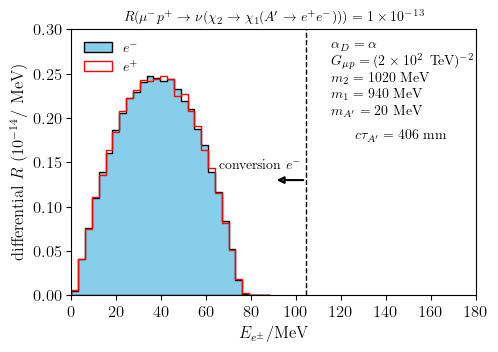

In [27]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

bins = np.linspace(0, max(np.max(kin_1['E_electron']), np.max(kin_1['E_positron']))*1e3, 30)

# Plot the histogram
ax.hist(kin_1['E_electron']*1e3, weights=1e14*weights_mucapture_1/(bins[1]-bins[0]), bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black', label='$e^-$')

# Plot the histogram
ax.hist(kin_1['E_positron']*1e3, weights=1e14*weights_mucapture_1/(bins[1]-bins[0]), bins=bins, histtype='step', color='skyblue', edgecolor='red', label='$e^+$')

# Set labels and title
ax.set_xlabel(r'$E_{e^\pm}$/MeV')
ax.set_ylabel(r'differential $R$ ($10^{-14}$/ MeV)')
ax.set_title(fr'$R(\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))) = {plot_tools.sci_notation(weights_mucapture_2.sum(), notex=True, decimal_digits=0)}$', fontsize=10)

# ax.set_yscale('log')

# Add the text box
ax.text(0.64, 0.95, Benchmark1.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.7, 0.62, fr'$c\tau_{{A^\prime}} = {Benchmark1.get_aprime_ctau0():.0f}$~mm', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.legend(loc='upper left', fontsize=10, frameon=False)

ax.vlines(104.2, 0, 2, color='black', linestyle='dashed', linewidth=1)

# Add arrow to the left attached to the vline
ax.annotate('', xy=(104.2, 0.13), xytext=(90, 0.13), arrowprops=dict(arrowstyle='<|-', lw=1.5))
ax.annotate('conversion $e^-$', xy=(102, 0.14), fontsize=10, ha='right', va = 'bottom')

# Set x ticks
ax.set_xticks(np.arange(0, 200, 20))
ax.set_ylim(0,0.3)
ax.set_xlim(0, 180)

# Save the figure to a PDF file
fig.savefig(f'plots/MuonCapture_model1_m1_{Benchmark1.m1*1e3:.0f}_E.png', bbox_inches='tight', dpi=300)

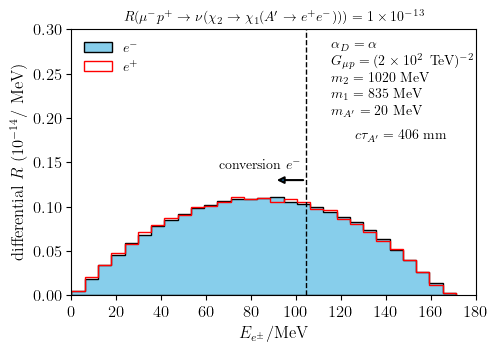

In [28]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

bins = np.linspace(0, max(np.max(kin_2['E_electron']), np.max(kin_2['E_positron']))*1e3, 30)

# Plot the histogram
ax.hist(kin_2['E_electron']*1e3, weights=1e14*weights_mucapture_2/(bins[1]-bins[0]), bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black', label='$e^-$')

# Plot the histogram
ax.hist(kin_2['E_positron']*1e3, weights=1e14*weights_mucapture_2/(bins[1]-bins[0]), bins=bins, histtype='step', color='skyblue', edgecolor='red', label='$e^+$')

# Set labels and title
ax.set_xlabel(r'$E_{e^\pm}$/MeV')
ax.set_ylabel(r'differential $R$ ($10^{-14}$/ MeV)')
ax.set_title(fr'$R(\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))) = {plot_tools.sci_notation(weights_mucapture_2.sum(), notex=True, decimal_digits=0)}$', fontsize=10)

# ax.set_yscale('log')

# Add the text box
ax.text(0.64, 0.95, Benchmark2.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.7, 0.62, fr'$c\tau_{{A^\prime}} = {Benchmark2.get_aprime_ctau0():.0f}$~mm', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.legend(loc='upper left', fontsize=10, frameon=False)

ax.vlines(104.2, 0, 2, color='black', linestyle='dashed', linewidth=1)

# Add arrow to the left attached to the vline
ax.annotate('', xy=(104.2, 0.13), xytext=(90, 0.13), arrowprops=dict(arrowstyle='<|-', lw=1.5))
ax.annotate('conversion $e^-$', xy=(102, 0.14), fontsize=10, ha='right', va = 'bottom')

# Set x ticks
ax.set_xticks(np.arange(0, 200, 20))
ax.set_ylim(0,0.3)
ax.set_xlim(0, 180)

# Save the figure to a PDF file
fig.savefig(f'plots/MuonCapture_model1_m1_{Benchmark2.m1*1e3:.0f}_p.png', bbox_inches='tight', dpi=300)

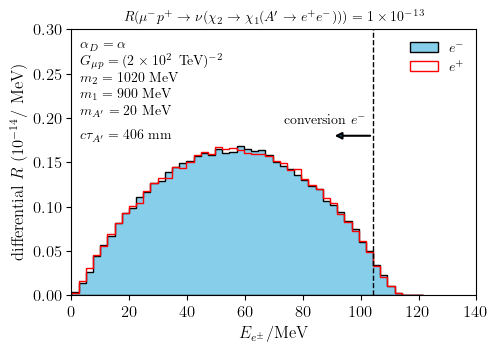

In [29]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

bins = np.linspace(0, max(np.max(kin_3['E_electron']), np.max(kin_3['E_positron']))*1e3, 50)

# Plot the histogram
ax.hist(kin_3['E_electron']*1e3, weights=1e14*weights_mucapture_3/(bins[1]-bins[0]), bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black', label='$e^-$')

# Plot the histogram
ax.hist(kin_3['E_positron']*1e3, weights=1e14*weights_mucapture_3/(bins[1]-bins[0]), bins=bins, histtype='step', color='skyblue', edgecolor='red', label='$e^+$')

# Set labels and title
ax.set_xlabel(r'$E_{e^\pm}$/MeV')
ax.set_ylabel(r'differential $R$ ($10^{-14}$/ MeV)')
ax.set_title(fr'$R(\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))) = {plot_tools.sci_notation(weights_mucapture_3.sum(), notex=True, decimal_digits=0)}$', fontsize=10)

# ax.set_yscale('log')

# Add the text box
ax.text(0.02, 0.95, Benchmark3.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.text(0.02, 0.62, fr'$c\tau_{{A^\prime}} = {Benchmark3.get_aprime_ctau0():.0f}$~mm', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.legend(loc='upper right', fontsize=10, frameon=False)

ax.vlines(104.2, 0, 2, color='black', linestyle='dashed', linewidth=1)

# Add arrow to the left attached to the vline
ax.annotate('', xy=(104.2, 0.13+0.05), xytext=(90, 0.13+0.05), arrowprops=dict(arrowstyle='<|-', lw=1.5))
ax.annotate('conversion $e^-$', xy=(102, 0.14+0.05), fontsize=10, ha='right', va = 'bottom')

# Set x ticks
ax.set_xticks(np.arange(0, 200, 20))
ax.set_ylim(0,0.3)
ax.set_xlim(0, 140)

# Save the figure to a PDF file
fig.savefig(f'plots/MuonCapture_model1_m1_{Benchmark3.m1*1e3:.0f}_p.png', bbox_inches='tight', dpi=300)

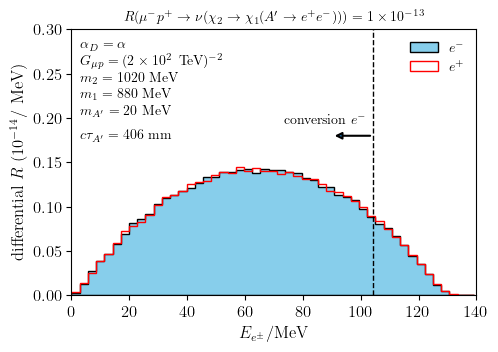

In [30]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

bins = np.linspace(0, max(np.max(kin_4['E_electron']), np.max(kin_4['E_positron']))*1e3, 50)

# Plot the histogram
ax.hist(kin_4['E_electron']*1e3, weights=1e14*weights_mucapture_3/(bins[1]-bins[0]), bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black', label='$e^-$')

# Plot the histogram
ax.hist(kin_4['E_positron']*1e3, weights=1e14*weights_mucapture_3/(bins[1]-bins[0]), bins=bins, histtype='step', color='skyblue', edgecolor='red', label='$e^+$')

# Set labels and title
ax.set_xlabel(r'$E_{e^\pm}$/MeV')
ax.set_ylabel(r'differential $R$ ($10^{-14}$/ MeV)')
ax.set_title(fr'$R(\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))) = {plot_tools.sci_notation(weights_mucapture_4.sum(), notex=True, decimal_digits=0)}$', fontsize=10)

# ax.set_yscale('log')

# Add the text box
ax.text(0.02, 0.95, Benchmark4.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.02, 0.62, fr'$c\tau_{{A^\prime}} = {Benchmark4.get_aprime_ctau0():.0f}$~mm', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.legend(loc='upper right', fontsize=10, frameon=False)

ax.vlines(104.2, 0, 2, color='black', linestyle='dashed', linewidth=1)

# Add arrow to the left attached to the vline
ax.annotate('', xy=(104.2, 0.13+0.05), xytext=(90, 0.13+0.05), arrowprops=dict(arrowstyle='<|-', lw=1.5))
ax.annotate('conversion $e^-$', xy=(102, 0.14+0.05), fontsize=10, ha='right', va = 'bottom')

# Set x ticks
ax.set_xticks(np.arange(0, 200, 20))
ax.set_ylim(0,0.3)
ax.set_xlim(0, 140)

# Save the figure to a PDF file
fig.savefig(f'plots/MuonCapture_model1_m1_{Benchmark4.m1*1e3:.0f}_p.png', bbox_inches='tight', dpi=300)

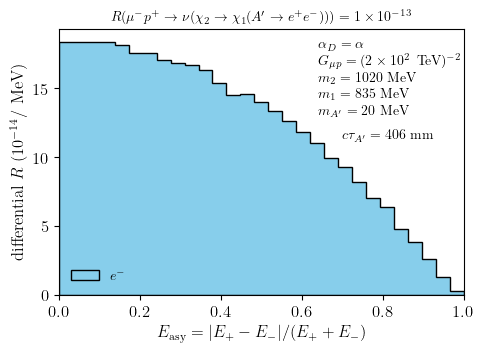

In [31]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

bins = np.linspace(0,1, 30)

# Plot the histogram
ax.hist(kin_2['E_asy'], weights=1e14*weights_mucapture_2/(bins[1]-bins[0]), bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black', label='$e^-$')

# Set labels and title
ax.set_xlabel(r'$E_{\rm asy} = |E_+ - E_-| / (E_+ + E_-)$')
ax.set_ylabel(r'differential $R$ ($10^{-14}$/ MeV)')
ax.set_title(fr'$R(\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))) = {plot_tools.sci_notation(weights_mucapture_2.sum(), notex=True, decimal_digits=0)}$', fontsize=10)

# ax.set_yscale('log')

# Add the text box
ax.text(0.64, 0.95, Benchmark2.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.7, 0.62, fr'$c\tau_{{A^\prime}} = {Benchmark1.get_aprime_ctau0():.0f}$~mm', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.legend(loc='lower left', fontsize=10, frameon=False)

ax.vlines(104.2, 0, 2, color='black', linestyle='dashed', linewidth=1)

# Add arrow to the left attached to the vline
ax.annotate('', xy=(104.2, 1), xytext=(90, 1), arrowprops=dict(arrowstyle='<|-', lw=1.5))
ax.annotate('conversion $e^-$', xy=(102, 1.05), fontsize=10, ha='right', va = 'bottom')

# Set x ticks
ax.set_xlim(0,1)

# Save the figure to a PDF file
fig.savefig(f'plots/MuonCapture_model1_m1_{Benchmark2.m1*1e3:.0f}_Easy.png', bbox_inches='tight', dpi=300)

## Proton decay studies

In [32]:
def get_p_lifetime(model):
    pevents = get_mgevents_pdecay(model, generate=True, process='pp > e+ vm~ ve vm chi1 Ap', nevents=1e3)
    g = (pevents['eventinfo','weight'].to_numpy() / len(pevents)).sum() * model.pdecay_rescale
    return const.get_decay_rate_in_1e32_years(g)

In [33]:
lifetimes = []
masses = np.linspace(0.835, const.m_proton - 0.020 - 0.003, 15, endpoint=True)
for m in masses:
    model = models.MuonCaptureModelI(m1=m, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD=const.alphaQED)
    lifetimes.append(get_p_lifetime(model))

stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 68562.63it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 67965.35it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 44670.72it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 53013.77it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 53311.93it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 43065.90it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 50723.75it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 53900.02it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 50655.98it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 58063.32it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 56425.89it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 58537.52it/s]
stty: stdin isn'

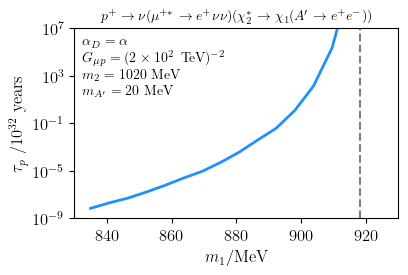

In [34]:
fig, ax = plot_tools.std_fig(figsize=(4, 2.5))

# y = lifetimes*((const.m_proton - (0.02 + masses)))**12
y = lifetimes
x = masses*1e3
ax.plot(x, y, color='dodgerblue', lw=2)

# Set labels and title
ax.set_xlabel(r'$m_1$/MeV')
ax.set_ylabel(r'$\tau_{p}$ /$10^{32}$ years')
ax.set_title(fr'$p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))$', fontsize=10)

ax.set_xlim(830, 930)

# Add the text box
descript = '\\noindent$\\alpha_D = \\alpha$\\\\$G_{\\mu p} = (2\\times 10^{2}$ \\,TeV$)^{-2}$\\\\$m_2 = 1020$ MeV\\\\$m_{A^\\prime} = 20$ MeV'
ax.text(0.025, 0.95, descript, transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Add the vertical dashed line
cutoff = (const.m_proton - Benchmark2.maprime)*1e3
ax.axvline(cutoff, linestyle='dashed', color='grey')

ax.set_yscale('log')

ax.set_ylim(1e-9,1e7)
# ax.set_ylim(1e-2,1)

# Save the figure to a PDF file
fig.savefig(f'plots/Proton_decay_mass_dependence.png', bbox_inches='tight', dpi=300)

In [35]:
pdecay_full_1 = get_mgevents_pdecay(Benchmark2, generate=True, process='pp > e+ vm~ ve vm chi1 e+ e-', nevents=1e5)
gamma_tot = (pdecay_full_1['eventinfo','weight'].to_numpy() / len(pdecay_full_1)).sum()* Benchmark1.pdecay_rescale
lifetime_1e32_1 = const.get_decay_rate_in_1e32_years(gamma_tot) 

weights_full_1 = pdecay_full_1['eventinfo','weight'].to_numpy() / pdecay_full_1['eventinfo','weight'].to_numpy().sum() * lifetime_1e32_1

stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 13318.10it/s]


In [36]:
pdecay_full_3 = get_mgevents_pdecay(Benchmark3, generate=True, process='pp > e+ vm~ ve vm chi1 e+ e-', nevents=1e5)
gamma_tot_3 = (pdecay_full_3['eventinfo','weight'].to_numpy() / len(pdecay_full_3)).sum()* Benchmark3.pdecay_rescale
lifetime_1e32_3 = const.get_decay_rate_in_1e32_years(gamma_tot_3) 

weights_full_3 = pdecay_full_3['eventinfo','weight'].to_numpy() / pdecay_full_3['eventinfo','weight'].to_numpy().sum() * lifetime_1e32_3

stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 37544.77it/s]


In [37]:
pdecay_aprime_2 = get_mgevents_pdecay(Benchmark2, generate=True, process='pp > e+ vm~ ve vm chi1 Ap', nevents=1e3)
gamma_tot_2 = (pdecay_aprime_2['eventinfo','weight'].to_numpy() / len(pdecay_aprime_2)).sum() * Benchmark2.pdecay_rescale
lifetime_1e32_aprime_2 = const.get_decay_rate_in_1e32_years(gamma_tot_2)
weights_full_2 = weights_full_1 / weights_full_1.sum() * lifetime_1e32_aprime_2

stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 68345.12it/s]


In [38]:
pdecay_aprime_3 = get_mgevents_pdecay(Benchmark3, generate=True, process='pp > e+ vm~ ve vm chi1 Ap', nevents=1e3)
lifetime_1e32_aprime_3 = const.get_decay_rate_in_1e32_years((pdecay_aprime_3['eventinfo','weight'].to_numpy() / len(pdecay_aprime_3)).sum() * Benchmark3.pdecay_rescale)
weights_full_3 = weights_full_3 / weights_full_3.sum() * lifetime_1e32_aprime_3

stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 66411.83it/s]


In [40]:
print(lifetime_1e32_aprime_2,lifetime_1e32_aprime_3)
weights_full_normalized = weights_full_1 / weights_full_1.sum() * lifetime_1e32_aprime_2
print(weights_full_normalized.sum())

6.991749426282554e-09 5.078433681803056
6.991749426282553e-09


In [41]:
def p_decay_kinematics(mgevents):
    electrons = (mgevents['particles', 'id'] == 11)
    positrons = (mgevents['particles', 'id'] == -11)
    neutrinos = (np.abs(mgevents['particles', 'id']) == 12) | (np.abs(mgevents['particles', 'id']) == 14)
    chi1s = (np.abs(mgevents['particles', 'id']) == 999901) 

    p_positron_1 = np.array([np.array(mgevents["particles", "vector", ind][positrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    p_positron_2 = np.array([np.array(mgevents["particles", "vector", ind][positrons]) for ind in ["t", "x", "y", "z"]])[:,:,1]
    p_electron = np.array([np.array(mgevents["particles", "vector", ind][electrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    ptot = (p_positron_1 + p_positron_2 + p_electron).T

    kin = {}
    kin['E_positrons'] = mgevents['particles','vector','t'][positrons].to_numpy().sum(axis=1)
    kin['E_electrons'] = mgevents['particles','vector','t'][electrons].to_numpy().sum(axis=1)
    kin['E_neutrinos'] = mgevents['particles','vector','t'][neutrinos].to_numpy().sum(axis=1)
    kin['E_chi1'] = mgevents['particles','vector','t'][chi1s].to_numpy().sum(axis=1)
    kin['E_vis'] = kin['E_electrons'] + kin['E_positrons']
    kin['T_vis'] = kin['E_vis'] - 2*const.m_e
    kin['E_inv'] = kin['E_neutrinos'] + kin['E_chi1']
    kin['E_asy'] = np.abs(kin['E_electrons'] - kin['E_positrons']) / (kin['E_electrons'] + kin['E_positrons'])
    kin['m_eee'] = np.sqrt(ptot[:, 0]**2 - ptot[:, 1]**2 - ptot[:, 2]**2 - ptot[:, 3]**2)

    return kin


In [42]:
kin_pdecay_2 = p_decay_kinematics(pdecay_full_1)
kin_pdecay_3 = p_decay_kinematics(pdecay_full_3)

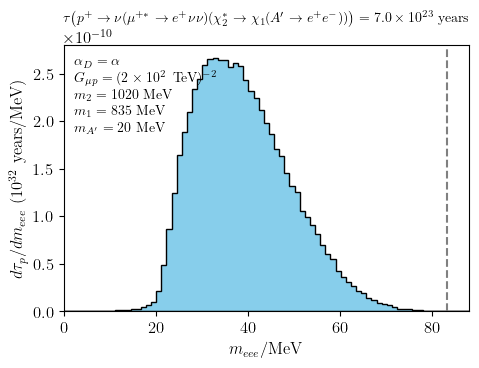

In [43]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, np.max(kin_pdecay_2['m_eee'])*1e3, 80)
ax.hist(kin_pdecay_2['m_eee']*1e3, weights=weights_full_2/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black')

# Set labels and title
ax.set_xlabel(r'$m_{eee}$/MeV')
ax.set_ylabel(r'${d \tau_{p}/d m_{eee}}$ ($10^{32}$ years/MeV)')
ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_1e32_aprime_2.sum()*1e32, notex=True)}$ years', fontsize=10)

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
ax.text(0.025, 0.95, Benchmark2.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')


# Add the vertical dashed line
cutoff = (const.m_proton - Benchmark2.m1 - Benchmark2.maprime)*1e3
ax.axvline(cutoff, linestyle='dashed', color='grey')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1_meee_m1_{Benchmark2.m1:0.0f}.png', bbox_inches='tight', dpi=300)

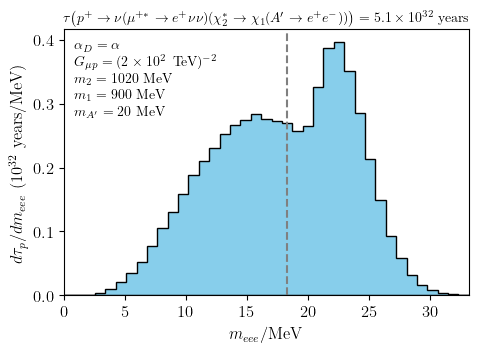

In [44]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, np.max(kin_pdecay_3['m_eee'])*1e3, 40)
ax.hist(kin_pdecay_3['m_eee']*1e3, weights=weights_full_3/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black')

# Set labels and title
ax.set_xlabel(r'$m_{eee}$/MeV')
ax.set_ylabel(r'${d \tau_{p}/d m_{eee}}$ ($10^{32}$ years/MeV)')
ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_1e32_aprime_3.sum()*1e32, notex=True)}$ years', fontsize=10)

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
ax.text(0.025, 0.95, Benchmark3.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')


# Add the vertical dashed line
cutoff = (const.m_proton - Benchmark3.m1 - Benchmark3.maprime)*1e3
ax.axvline(cutoff, linestyle='dashed', color='grey')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1_meee_m1_{Benchmark3.m1:0.0f}.png', bbox_inches='tight', dpi=300)

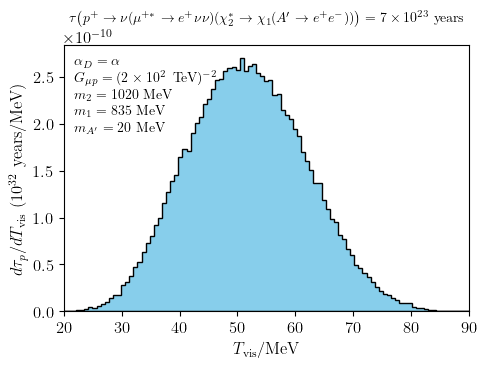

In [45]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(20, 90, 100)
ax.hist(kin_pdecay_2['T_vis']*1e3, weights=weights_full_2/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black')

# Set labels and title
ax.set_xlabel(r'$T_{\mathrm{vis}}$/MeV')
ax.set_ylabel(r'${d \tau_{p}/d T_{\rm vis}}$ ($10^{32}$ years/MeV)')
ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_1e32_aprime_2*1e32, notex=True, decimal_digits=0)}$ years', fontsize=10)

# ax.set_yscale('log')

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
ax.text(0.025, 0.95, Benchmark2.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Add the vertical dashed line
# cutoff = 938.27 - (m1+mAp)*1e3 - 3*0.511
# ax.axvline(cutoff, linestyle='dashed', color='grey')
# ax.text(cutoff+0.5, ax.get_ylim()[1]/10, r'$m_p - m_1 - 3 m_e$', rotation='vertical', color='grey', ha='left', va='bottom')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1_Tvis_m1_{Benchmark2.m1:0.0f}.png', bbox_inches='tight', dpi=300)

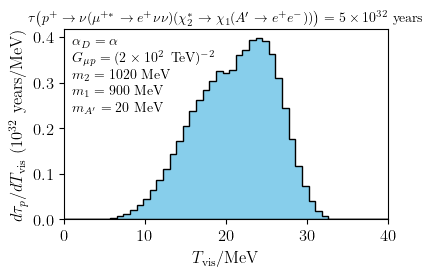

In [46]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(4, 2.5))

# Plot the histogram
bins = np.linspace(0, 40, 50)
ax.hist(kin_pdecay_3['T_vis']*1e3, weights=weights_full_3/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black')

# Set labels and title
ax.set_xlabel(r'$T_{\mathrm{vis}}$/MeV')
ax.set_ylabel(r'${d \tau_{p}/d T_{\rm vis}}$ ($10^{32}$ years/MeV)')
ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_1e32_aprime_3*1e32, notex=True, decimal_digits=0)}$ years', fontsize=10)

# ax.set_yscale('log')

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
ax.text(0.025, 0.95, Benchmark3.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1_Tvis_m1_{Benchmark3.m1:0.0f}.png', bbox_inches='tight', dpi=300)